In [1]:
import math

import numpy as np
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import os
import pathlib
from typing import Tuple, Dict, List
from pathlib import Path

In [2]:
# check the version
print(torch.__version__)

1.13.1+cu116


In [3]:
# check if gpu/cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile

zip_path = '/content/drive/MyDrive/comp5625M_data_assessment_1.zip'
image_path = Path("/content/TinyImage30")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/TinyImage30')

In [6]:
# Setup train and testing paths
train_dir = '/content/TinyImage30/train_set/train_set'
test_dir = '/content/TinyImage30/test_set/test_set'

train_dir, test_dir

('/content/TinyImage30/train_set/train_set',
 '/content/TinyImage30/test_set/test_set')

In [7]:
#Finds the class folder names in a target directory

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  #class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  #Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  #Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [8]:
#Custom dataset class

#Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  #Initialize custom dataset
  def __init__(self, targ_dir: str, transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.*"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  #Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path).convert('RGB')

  #Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)
  
  #Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [9]:
# Create a transform

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [10]:
#Training dataset
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

In [11]:
#Split data into train and validation sets

import torch.utils.data as data

train_size = int(0.8 * len(train_data_custom)) # Use 80% of the data for training
val_size = len(train_data_custom) - train_size # Use the remaining 20% for validation

train_data, val_data = data.random_split(train_data_custom, [train_size, val_size],generator=torch.Generator().manual_seed(0))

In [12]:
len(train_data), len(val_data)

(10800, 2700)

In [13]:
#Creating train and validation data loaders

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

val_dataloader_custom = DataLoader(dataset=val_data,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)


train_dataloader_custom, val_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f9e5fff9e80>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9e5fff9d00>)

In [14]:
# Prints difference between start and end time

from timeit import default_timer as timer
from tqdm.auto import tqdm
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
#MLP Class

class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(MLPModel, self).__init__()
        self.activation = activation
        
        # Define the layers of the model
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = nn.Flatten()(x)
        
        # Apply the activation function to the hidden layer
        x = self.activation(self.fc1(x))
        
        # Apply the output layer
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate the model
torch.manual_seed(42)
model_1 = MLPModel(input_dim = 12288, hidden_dim = 500, output_dim = 30, activation = nn.Sigmoid()).to(device)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_MLP = optim.Adam(model_1.parameters(), lr=0.0001)

In [15]:
# Create a convolutional neural network
class CNNModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        # Define the first convolutional block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Define the second convolutional block
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Define the classifier block
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [16]:
#create an instance of the model
torch.manual_seed(42)
model_2 = CNNModel(input_shape=3,
                   hidden_units=50,
                   output_shape=len(train_data_custom.classes)).to(device) 

In [17]:
#loss function and optimizer for the CNN model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                            lr=0.0001)

Model training


Training both MLP and CNN models with loss and accuracy graphs 

In [18]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [19]:
# Function to perform a training loop step on a model

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    total_training_accuracy=0

    # Put model into training mode
    model.train()

    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device 
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y.long())
        train_loss += loss.item()
        train_top_acc = topk_accuracy(y_pred,y)
        total_training_accuracy += train_top_acc[0]

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

    # Divide total train loss and acc by length of train dataloader
    train_loss /= len(data_loader)
    train_acc = total_training_accuracy / len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")
    return train_loss,train_acc

In [20]:
# Function to perform a validation loop step on a model
def valid_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  valid_loss, valid_acc = 0, 0
  total_validation_accuracy=0
  
  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      valid_pred = model(X)

      # Calculuate the loss/acc
      valid_loss += loss_fn(valid_pred, y)
      val_top_acc = topk_accuracy(valid_pred,y)
      total_validation_accuracy += val_top_acc[0]

    # Adjust metrics and print out
    valid_loss /= len(data_loader)
    valid_acc = total_validation_accuracy / len(data_loader)
    print(f"Validation loss: {valid_loss:.5f} | Validation acc: {valid_acc:.2f}%\n")
    return valid_loss,valid_acc

In [ ]:
# create lists to store loss and accuracy values for training and validation sets
train_loss_MLP = []
train_acc_MLP = []
val_loss_MLP = []
val_acc_MLP = []

In [ ]:
# Running the MLP model class

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_1 = timer() 

# Train and validation model
epochs = 20
for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc = train_step(model=model_1,
             data_loader=train_dataloader_custom,
             loss_fn=criterion,
             optimizer=optimizer_MLP,
             device=device)
  val_loss, val_acc = valid_step(model=model_1,
            data_loader=val_dataloader_custom,
            loss_fn=criterion,
            device=device)
  train_loss_MLP.append(train_loss)
  train_acc_MLP.append(train_acc)
  val_loss_MLP.append(val_loss.cpu().numpy())
  val_acc_MLP.append(val_acc)

train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                            end=train_time_end_model_1,
                                            device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 3.04875 | Train acc: 15.51%
Validation loss: 2.94661 | Validation acc: 17.79%

Epoch: 2
-------
Train loss: 2.87049 | Train acc: 19.26%
Validation loss: 2.88829 | Validation acc: 19.29%

Epoch: 3
-------
Train loss: 2.79841 | Train acc: 21.24%
Validation loss: 2.83785 | Validation acc: 19.91%

Epoch: 4
-------
Train loss: 2.74890 | Train acc: 22.52%
Validation loss: 2.82552 | Validation acc: 19.25%

Epoch: 5
-------
Train loss: 2.70934 | Train acc: 23.70%
Validation loss: 2.80427 | Validation acc: 20.55%

Epoch: 6
-------
Train loss: 2.68156 | Train acc: 24.31%
Validation loss: 2.77635 | Validation acc: 22.08%

Epoch: 7
-------
Train loss: 2.64876 | Train acc: 25.66%
Validation loss: 2.75014 | Validation acc: 21.37%

Epoch: 8
-------
Train loss: 2.62663 | Train acc: 25.99%
Validation loss: 2.75124 | Validation acc: 21.45%

Epoch: 9
-------
Train loss: 2.60750 | Train acc: 26.57%
Validation loss: 2.72557 | Validation acc: 22.89%

Epoch: 10
-------
Train loss

In [ ]:
#function to plot graph

def plot_graph(train_loss, train_acc, val_loss, val_acc):
  val_loss = [torch.from_numpy(l).cpu().numpy() for l in val_loss]
  val_acc = [a.cpu().numpy() for a in val_acc]
  train_acc = [a.cpu().numpy() for a in train_acc]
  
  plt.figure(figsize=(12, 4))
  
  plt.subplot(1, 2, 1)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss') 
  plt.legend()
  
  plt.subplot(1, 2, 2)
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy') 
  plt.legend()
  
  plt.show()

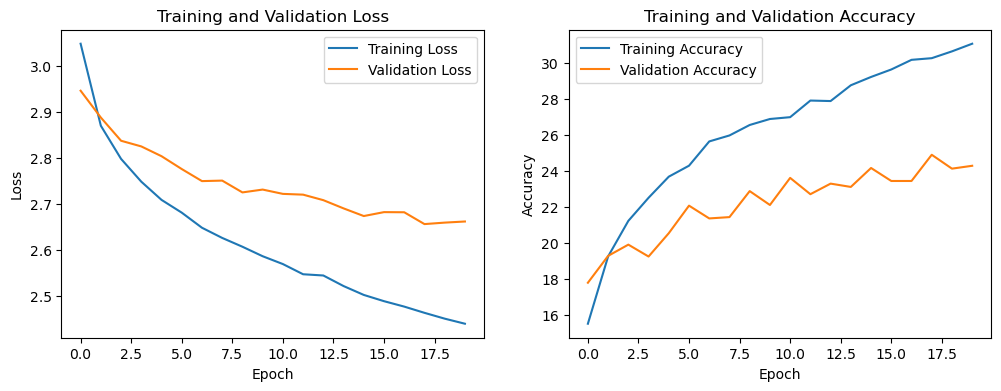

In [ ]:
# MLP graph

plot_graph(train_loss_MLP,train_acc_MLP,val_loss_MLP,val_acc_MLP)

In [ ]:
# create lists to store loss and accuracy values for training and validation sets
train_loss_CNN = []
train_acc_CNN = []
val_loss_CNN = []
val_acc_CNN = []

In [ ]:
# Running the CNN model class

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_2 = timer() 

# Train and test model
epochs = 20
for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc = train_step(model=model_2,
             data_loader=train_dataloader_custom,
             loss_fn=loss_fn,
             optimizer=optimizer,
             device=device)
  val_loss, val_acc = valid_step(model=model_2,
            data_loader=val_dataloader_custom,
            loss_fn=loss_fn,
            device=device)
  train_loss_CNN.append(train_loss)
  train_acc_CNN.append(train_acc)
  val_loss_CNN.append(val_loss.cpu().numpy())
  val_acc_CNN.append(val_acc)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 2.76972 | Train acc: 21.71%
Validation loss: 2.41428 | Validation acc: 29.95%

Epoch: 2
-------
Train loss: 2.34407 | Train acc: 32.98%
Validation loss: 2.31800 | Validation acc: 33.53%

Epoch: 3
-------
Train loss: 2.18436 | Train acc: 36.58%
Validation loss: 2.18960 | Validation acc: 38.06%

Epoch: 4
-------
Train loss: 2.04650 | Train acc: 40.84%
Validation loss: 2.16560 | Validation acc: 37.81%

Epoch: 5
-------
Train loss: 1.96965 | Train acc: 43.48%
Validation loss: 2.08422 | Validation acc: 41.23%

Epoch: 6
-------
Train loss: 1.89671 | Train acc: 44.89%
Validation loss: 2.02045 | Validation acc: 41.16%

Epoch: 7
-------
Train loss: 1.82986 | Train acc: 47.68%
Validation loss: 2.00254 | Validation acc: 40.94%

Epoch: 8
-------
Train loss: 1.78539 | Train acc: 48.00%
Validation loss: 1.98562 | Validation acc: 42.88%

Epoch: 9
-------
Train loss: 1.72841 | Train acc: 49.70%
Validation loss: 1.92817 | Validation acc: 43.60%

Epoch: 10
-------
Train loss

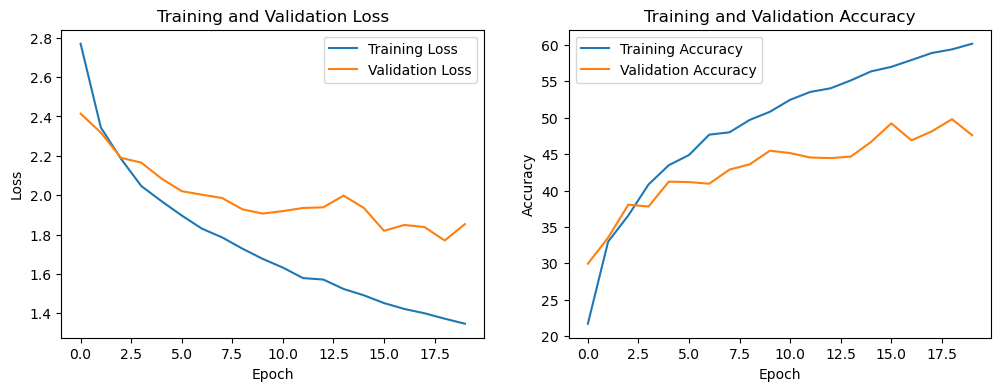

In [ ]:
# CNN graph

plot_graph(train_loss_CNN,train_acc_CNN,val_loss_CNN,val_acc_CNN)

In [ ]:
#Save trained CNN model
torch.save(model_2.state_dict(),'FinalCNN.pth')

MLPModel and CNNModel are two different neural network architectures for image classification tasks. While MLPModel is a fully connected neural network, CNNModel is a convolutional neural network that can learn spatial features from images.

In terms of the number of parameters, the MLPModel has fewer parameters than the CNNModel, as it only has two fully connected layers. In contrast, the CNNModel has more parameters due to the presence of convolutional and pooling layers.

The MLPModel, after 20 epochs of training, gives the following results:             
Train loss: 2.44015 | Train acc: 31.09% | Validation loss: 2.66234 | Validation acc: 24.30%

These values indicate that the model is not performing very well on the task, as the accuracy on both the training and validation sets is relatively low. The difference between the training and validation accuracies is also quite large, which suggests that the model is overfitting to the training data.

The CNNModel, after 20 epochs of training, gives the following results:             
Train loss: 1.34697 | Train acc: 60.17% | 
Validation loss: 1.85309 | Validation acc: 47.60%

These values indicate that the model is performing reasonably well on the task, as the accuracy on both the training and validation sets is much higher than the corresponding values for the MLPModel. The difference between the training and validation accuracies is also smaller than for the MLPModel, which suggests that the model is not overfitting as much.

CNNs are more suitable than MLPs for image classification tasks because they can learn local patterns and spatial relationships between pixels in an image. This is achieved through the use of convolutional layers. 

Thus, we can conclude that a convolutional neural network is better suited for image classification tasks than an MLP model.

### Confusion matrix and ROC curves

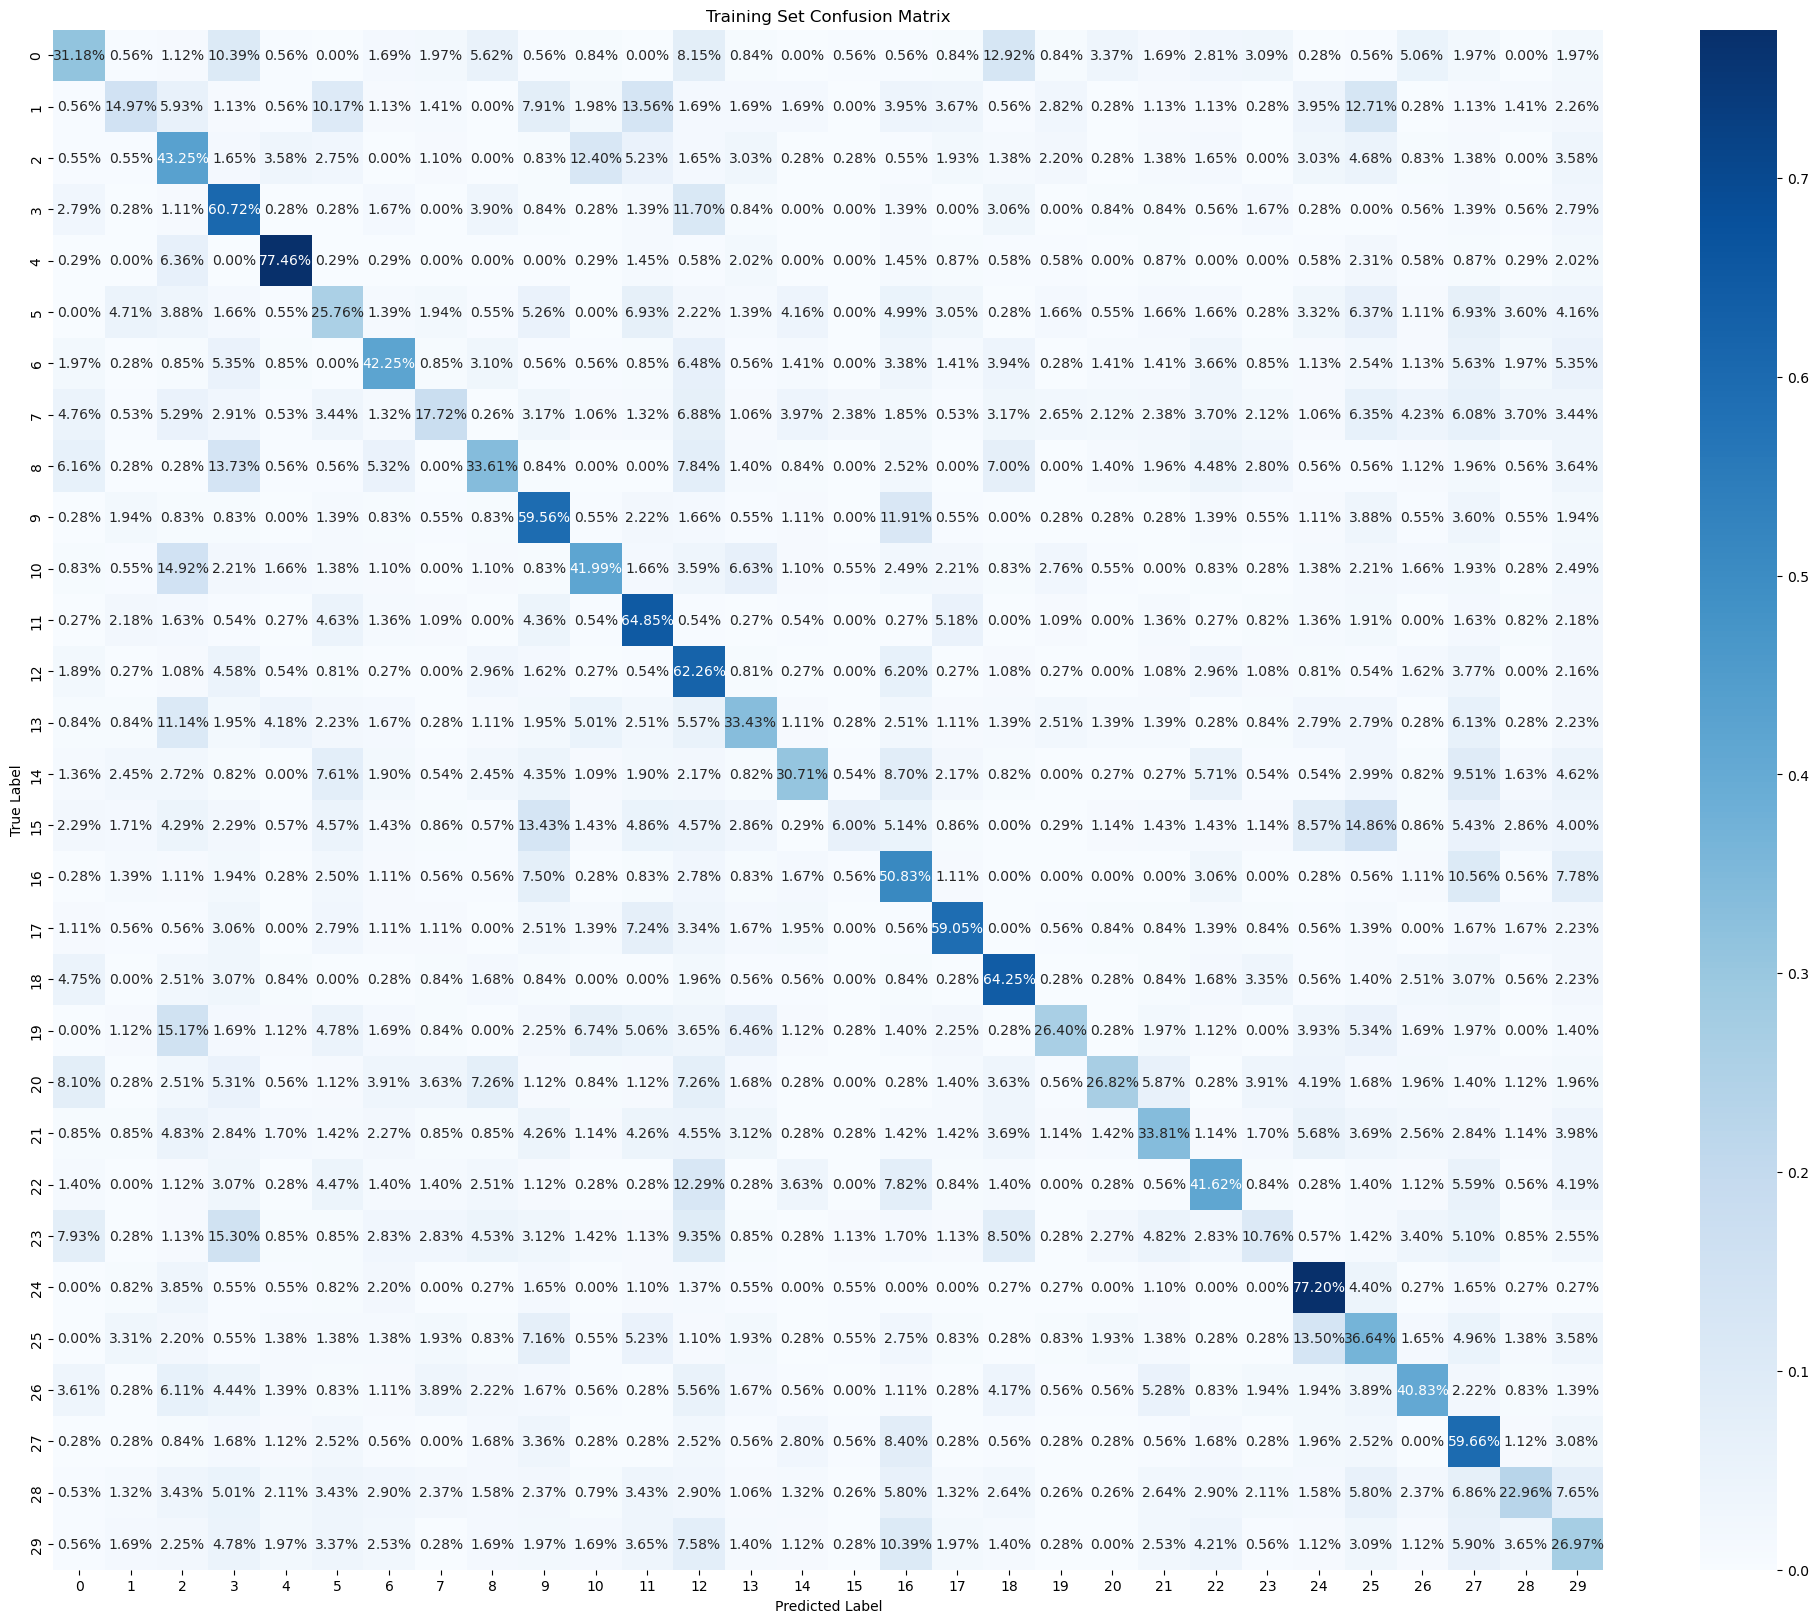

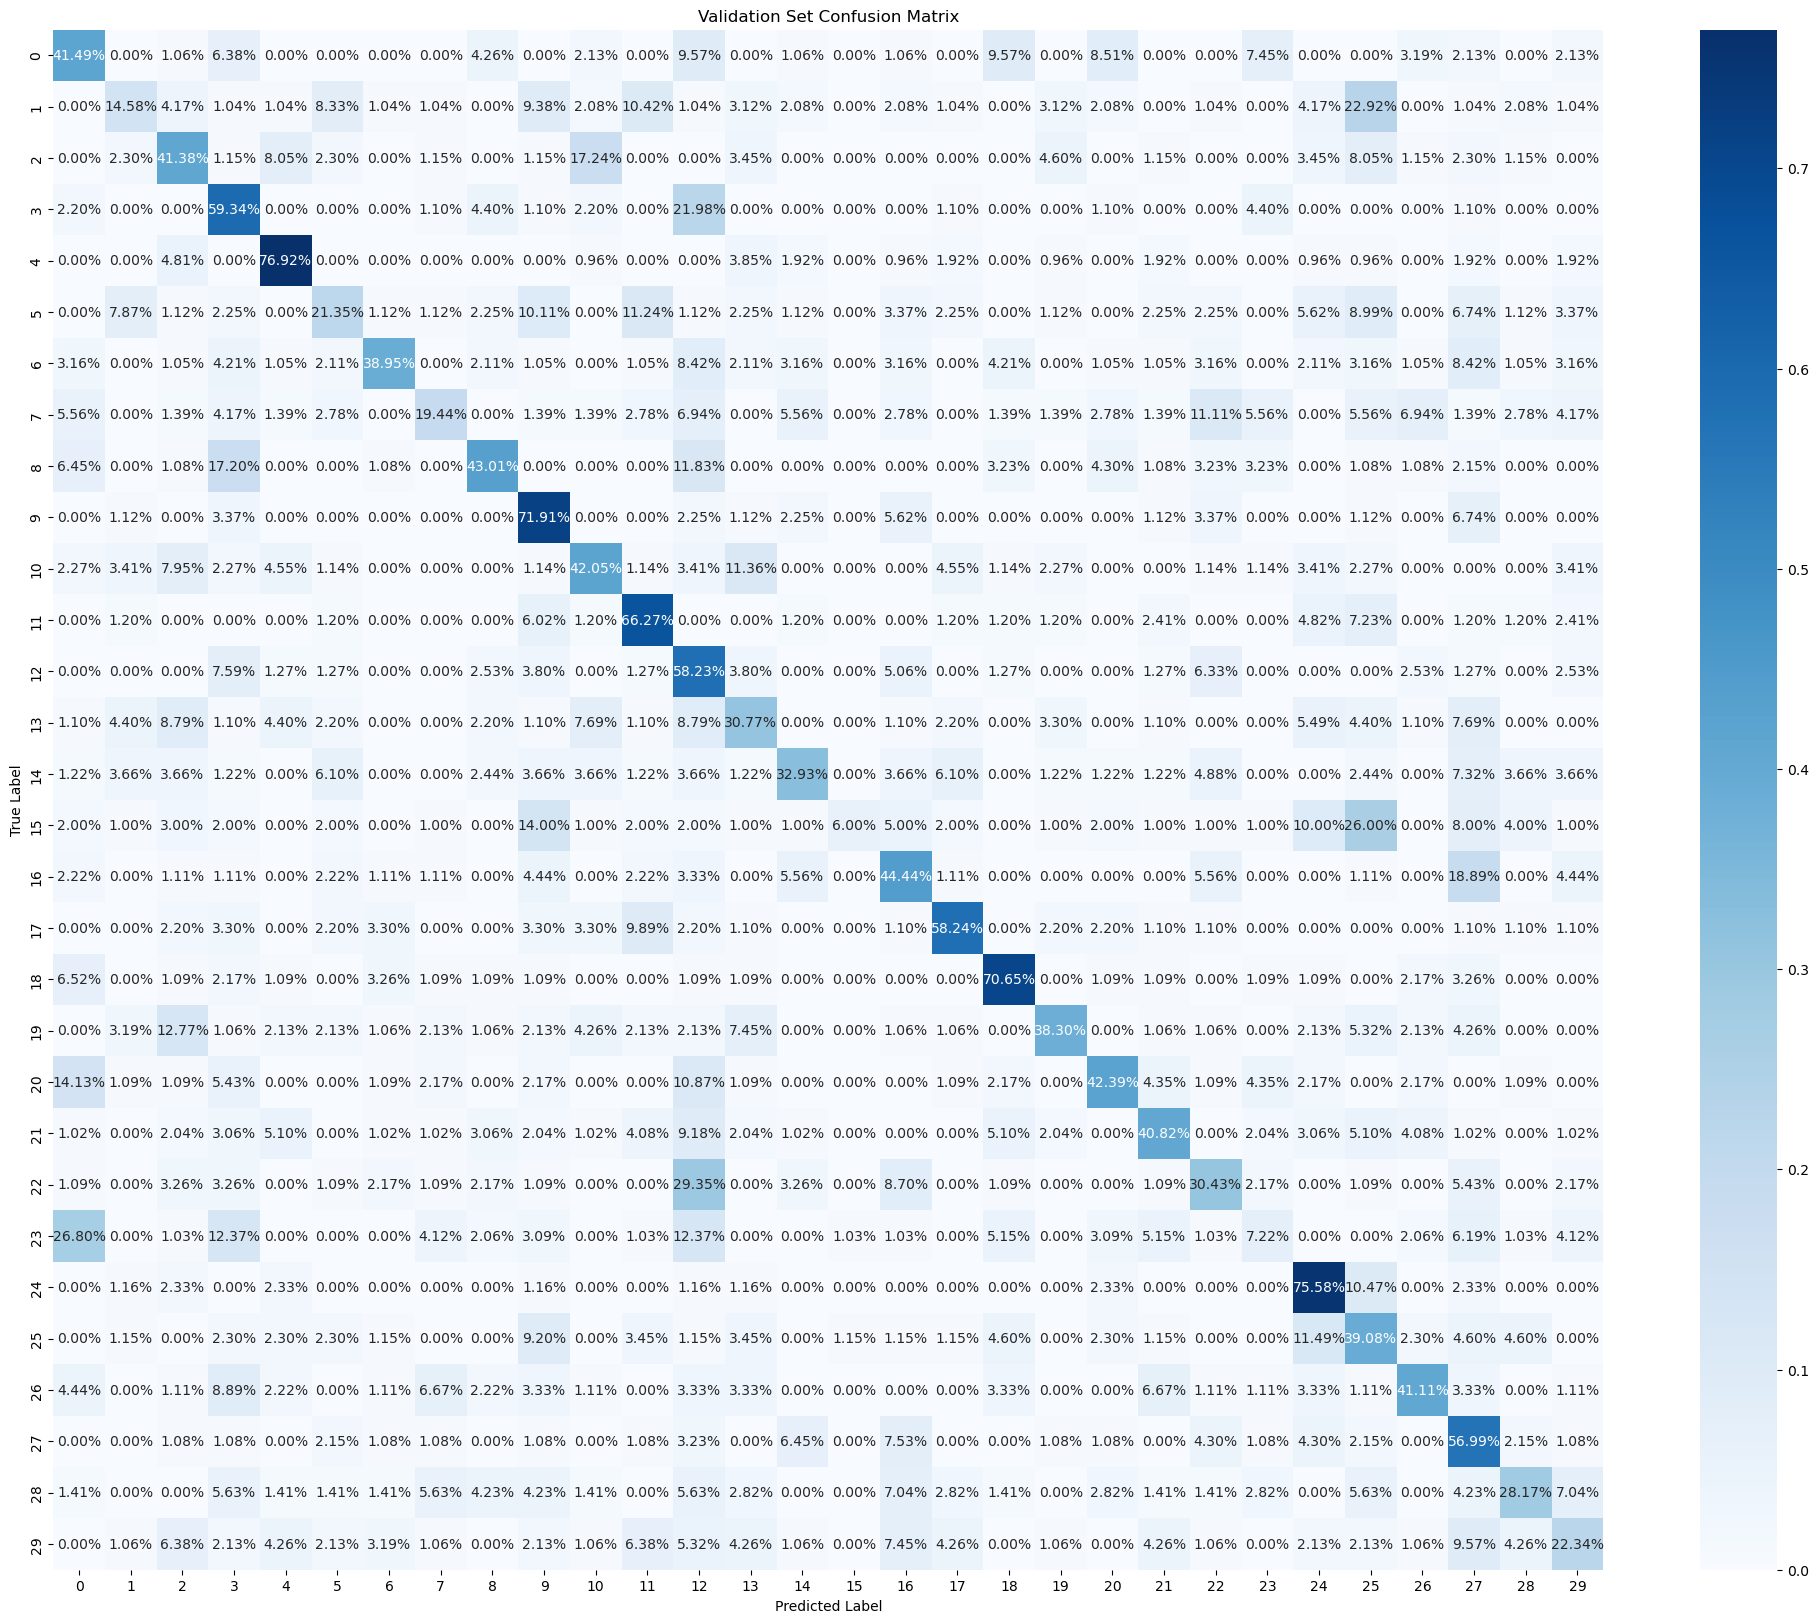

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define function to generate confusion matrix
def generate_confusion_matrix(model, data_loader):
    num_classes = len(train_data_custom.classes)
    confusion_matrix = np.zeros((num_classes, num_classes))
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(predicted)):
                confusion_matrix[labels[i]][predicted[i]] += 1
    return confusion_matrix

# Generate confusion matrix for training set
train_confusion_matrix = generate_confusion_matrix(model_cnn_da, train_dataloader_custom_da)
train_percentages = train_confusion_matrix / np.sum(train_confusion_matrix, axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(train_percentages, annot=True, fmt=".2%", cmap="Blues")
plt.title("Training Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Generate confusion matrix for validation set
val_confusion_matrix = generate_confusion_matrix(model_cnn_da, val_dataloader_custom)
val_percentages = val_confusion_matrix / np.sum(val_confusion_matrix, axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(val_percentages, annot=True, fmt=".2%", cmap="Blues")
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for test data
with torch.no_grad():
    model_2.eval()
    y_pred = []
    y_true = []
    for inputs, labels in train_dataloader_custom:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_2(inputs)
        y_pred.append(outputs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)

fprs, tprs, aucs = [], [], []
for i in range(5):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, i])
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))

# Plot ROC curves and display AUC values
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(5):
    plt.plot(fprs[i], tprs[i], label=f"Class {i} (AUC = {aucs[i]:.3f})")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

#### Data augmentation

In [ ]:
# Data augmentation

# Create a new instance
torch.manual_seed(42)

model_cnn_da = CNNModel(input_shape=3,
                   hidden_units=50,
                   output_shape=len(train_data_custom.classes)).to(device)

In [ ]:
# Peform Data Augmentation

data_aug_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomInvert(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
#New Training dataset
train_data_custom_da = ImageFolderCustom(targ_dir=train_dir,
                                      transform=data_aug_transforms)

In [ ]:
import torch.utils.data as data

train_size = int(0.8 * len(train_data_custom_da)) # Use 80% of the data for training
val_size = len(train_data_custom_da) - train_size # Use the remaining 20% for validation

train_data_da, val_data_da = data.random_split(train_data_custom_da, [train_size, val_size],generator=torch.Generator().manual_seed(0))

In [ ]:
#Creating train and validation data loaders

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom_da = DataLoader(dataset=train_data_da,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

train_dataloader_custom_da

In [ ]:
optimizer_da = torch.optim.Adam(params=model_cnn_da.parameters(),
                            lr=0.0001)

In [ ]:
# create lists to store loss and accuracy values for training and validation sets
train_loss_CNN_da = []
train_acc_CNN_da = []
val_loss_CNN_da = []
val_acc_CNN_da = []

In [ ]:
# Running the CNN model class

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_da = timer() 

# Train and test model
epochs = 50
for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc = train_step(model=model_cnn_da,
             data_loader=train_dataloader_custom_da,
             loss_fn=loss_fn,
             optimizer=optimizer_da,
             device=device)
  val_loss, val_acc = valid_step(model=model_cnn_da,
            data_loader=val_dataloader_custom,
            loss_fn=loss_fn,
            device=device)
  train_loss_CNN_da.append(train_loss)
  train_acc_CNN_da.append(train_acc)
  val_loss_CNN_da.append(val_loss.cpu().numpy())
  #val_loss_CNN_da.append(val_loss)
  val_acc_CNN_da.append(val_acc)

train_time_end_model_da = timer()
total_train_time_model_da = print_train_time(start=train_time_start_model_da,
                                            end=train_time_end_model_da,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 3.26748 | Train acc: 10.56%
Validation loss: 2.93891 | Validation acc: 17.45%

Epoch: 2
-------
Train loss: 3.01647 | Train acc: 15.21%
Validation loss: 2.84303 | Validation acc: 19.75%

Epoch: 3
-------
Train loss: 2.90500 | Train acc: 18.43%
Validation loss: 2.73522 | Validation acc: 21.69%

Epoch: 4
-------
Train loss: 2.84691 | Train acc: 19.51%
Validation loss: 2.67345 | Validation acc: 22.68%

Epoch: 5
-------
Train loss: 2.81431 | Train acc: 20.48%
Validation loss: 2.69965 | Validation acc: 23.31%

Epoch: 6
-------
Train loss: 2.76736 | Train acc: 21.23%
Validation loss: 2.57911 | Validation acc: 25.80%

Epoch: 7
-------
Train loss: 2.71738 | Train acc: 22.50%
Validation loss: 2.57058 | Validation acc: 25.15%

Epoch: 8
-------
Train loss: 2.69841 | Train acc: 23.49%
Validation loss: 2.50036 | Validation acc: 27.57%

Epoch: 9
-------
Train loss: 2.65846 | Train acc: 24.71%
Validation loss: 2.51977 | Validation acc: 27.86%

Epoch: 10
-------
Train loss

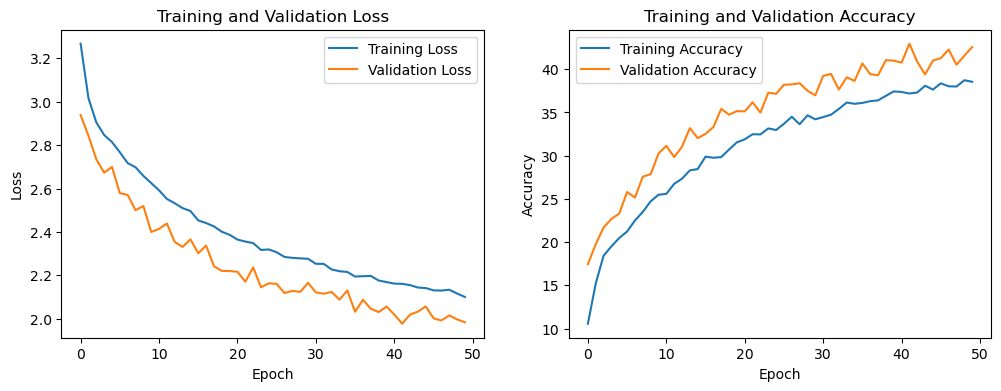

In [ ]:
#graph

plot_graph(train_loss_CNN_da,train_acc_CNN_da,val_loss_CNN_da,val_acc_CNN_da)

The validation accuracy has improved after applying data augmentation techniques. This indicates that data augmentation can help improve model performance by introducing more variations in the training data and reducing overfitting. 
By introducing these variations into the training data, the model is forced to learn more generalizable features that can better capture the underlying structure of the images.

#### Dropout


In [ ]:
# Dropout

# Create a new instance
torch.manual_seed(42)

model_cnn_dropout = CNNModel(input_shape=3,
                   hidden_units=50,
                   output_shape=len(train_data_custom.classes)).to(device)

In [ ]:
# Dropout

class ModifiedCNNModel(nn.Module):
    def __init__(self):
        super(ModifiedCNNModel, self).__init__()
        self.model = model_cnn_dropout
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

modified_model = ModifiedCNNModel()
modified_model.model.load_state_dict(model_cnn_dropout.state_dict())

<All keys matched successfully>

In [ ]:
# create lists to store loss and accuracy values for training and validation sets
train_loss_dp = []
train_acc_dp = []
val_loss_dp = []
val_acc_dp = []

In [ ]:
# Running the CNN model class after adding dropout layers

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_dp = timer() 

# Train and test model
epochs = 30
for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc = train_step(model=modified_model,
             data_loader=train_dataloader_custom,
             loss_fn=loss_fn,
             optimizer=optimizer,
             device=device)
  val_loss, val_acc = valid_step(model=modified_model,
            data_loader=val_dataloader_custom,
            loss_fn=loss_fn,
            device=device)
  train_loss_dp.append(train_loss)
  train_acc_dp.append(train_acc)
  val_loss_dp.append(val_loss.cpu().numpy())
  #val_loss_dp.append(val_loss)
  val_acc_dp.append(val_acc)

train_time_end_model_dp = timer()
total_train_time_model_dp = print_train_time(start=train_time_start_model_dp,
                                            end=train_time_end_model_dp,
                                            device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 3.79523 | Train acc: 3.30%
Validation loss: 3.59570 | Validation acc: 3.46%

Epoch: 2
-------
Train loss: 3.81089 | Train acc: 3.56%
Validation loss: 3.59749 | Validation acc: 3.63%

Epoch: 3
-------
Train loss: 3.81843 | Train acc: 3.12%
Validation loss: 3.60963 | Validation acc: 3.20%

Epoch: 4
-------
Train loss: 3.80114 | Train acc: 3.62%
Validation loss: 3.58474 | Validation acc: 3.55%

Epoch: 5
-------
Train loss: 3.79832 | Train acc: 3.74%
Validation loss: 3.58607 | Validation acc: 3.86%

Epoch: 6
-------
Train loss: 3.80601 | Train acc: 3.37%
Validation loss: 3.60369 | Validation acc: 3.35%

Epoch: 7
-------
Train loss: 3.80545 | Train acc: 3.34%
Validation loss: 3.59800 | Validation acc: 3.68%

Epoch: 8
-------
Train loss: 3.80652 | Train acc: 3.37%
Validation loss: 3.60446 | Validation acc: 3.15%

Epoch: 9
-------
Train loss: 3.79513 | Train acc: 3.34%
Validation loss: 3.59427 | Validation acc: 3.41%

Epoch: 10
-------
Train loss: 3.80105 | Train 

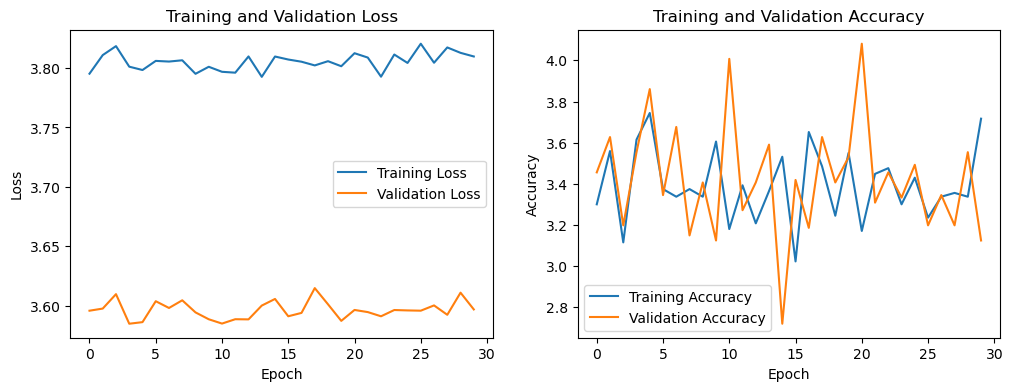

In [ ]:
#graph
plot_graph(train_loss_dp,train_acc_dp,val_loss_dp,val_acc_dp)

Here, dropout regularization is applied to the input tensor by randomly setting elements to zero with probability 0.5 during training.

#### Hyperparameter tuning


In [ ]:
# Create a new instance
torch.manual_seed(42)

model_cnn_hpt1 = CNNModel(input_shape=3,
                   hidden_units=50,
                   output_shape=len(train_data_custom.classes)).to(device)
model_cnn_hpt2 = CNNModel(input_shape=3,
                   hidden_units=50,
                   output_shape=len(train_data_custom.classes)).to(device)
model_cnn_hpt3 = CNNModel(input_shape=3,
                   hidden_units=50,
                   output_shape=len(train_data_custom.classes)).to(device)

In [ ]:
# Hyperparameter tuning
# For my base CNN model, I have used learning rate = 0.0001. 
# Therefore, for this question, I have used the following learning rates.

lr_1 = 0.1
lr_2 = 0.001
lr_3 = 0.00001

optimizer_hpt1 = torch.optim.Adam(params=model_cnn_hpt1.parameters(),lr=lr_1)
optimizer_hpt2 = torch.optim.Adam(params=model_cnn_hpt2.parameters(),lr=lr_2)
optimizer_hpt3 = torch.optim.Adam(params=model_cnn_hpt3.parameters(),lr=lr_3)

In [ ]:
# create lists to store loss and accuracy values for training and validation sets
train_loss_hpt1 = []
train_acc_hpt1 = []
val_loss_hpt1 = []
val_acc_hpt1 = []

# Running the CNN model class for learning rate = 0.1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_hpt1 = timer() 

# Train and test model
epochs = 15
for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc = train_step(model=model_cnn_hpt1,
             data_loader=train_dataloader_custom,
             loss_fn=loss_fn,
             optimizer=optimizer_hpt1,
             device=device)
  val_loss, val_acc = valid_step(model=model_cnn_hpt1,
            data_loader=val_dataloader_custom,
            loss_fn=loss_fn,
            device=device)
  train_loss_hpt1.append(train_loss)
  train_acc_hpt1.append(train_acc)
  val_loss_hpt1.append(val_loss.cpu().numpy())
  #val_loss_hpt1.append(val_loss)
  val_acc_hpt1.append(val_acc)

train_time_end_model_hpt1 = timer()
total_train_time_model_hpt1 = print_train_time(start=train_time_start_model_hpt1,
                                            end=train_time_end_model_hpt1,
                                            device=device)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 9.81509 | Train acc: 2.97%
Validation loss: 3.42566 | Validation acc: 3.38%

Epoch: 2
-------
Train loss: 3.42572 | Train acc: 3.24%
Validation loss: 3.41874 | Validation acc: 3.33%

Epoch: 3
-------
Train loss: 3.42533 | Train acc: 3.23%
Validation loss: 3.41888 | Validation acc: 3.53%

Epoch: 4
-------
Train loss: 3.42525 | Train acc: 3.21%
Validation loss: 3.42807 | Validation acc: 3.59%

Epoch: 5
-------
Train loss: 3.42497 | Train acc: 3.05%
Validation loss: 3.41941 | Validation acc: 3.38%

Epoch: 6
-------
Train loss: 3.42381 | Train acc: 3.08%
Validation loss: 3.42156 | Validation acc: 3.27%

Epoch: 7
-------
Train loss: 3.42252 | Train acc: 3.25%
Validation loss: 3.41560 | Validation acc: 3.53%

Epoch: 8
-------
Train loss: 3.42527 | Train acc: 3.34%
Validation loss: 3.42908 | Validation acc: 3.01%

Epoch: 9
-------
Train loss: 3.42550 | Train acc: 3.61%
Validation loss: 3.42413 | Validation acc: 3.16%

Epoch: 10
-------
Train loss: 3.42555 | Train 

In [ ]:
# create lists to store loss and accuracy values for training and validation sets
train_loss_hpt2 = []
train_acc_hpt2 = []
val_loss_hpt2 = []
val_acc_hpt2 = []

# Running the CNN model class for learning rate = 0.001

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_hpt2 = timer() 

# Train and test model
epochs = 15
for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc = train_step(model=model_cnn_hpt2,
             data_loader=train_dataloader_custom,
             loss_fn=loss_fn,
             optimizer=optimizer_hpt2,
             device=device)
  val_loss, val_acc = valid_step(model=model_cnn_hpt2,
            data_loader=val_dataloader_custom,
            loss_fn=loss_fn,
            device=device)
  train_loss_hpt2.append(train_loss)
  train_acc_hpt2.append(train_acc)
  val_loss_hpt2.append(val_loss.cpu().numpy())
  #val_loss_hpt2.append(val_loss)
  val_acc_hpt2.append(val_acc)

train_time_end_model_hpt2 = timer()
total_train_time_model_hpt2 = print_train_time(start=train_time_start_model_hpt2,
                                            end=train_time_end_model_hpt2,
                                            device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 1.29106 | Train acc: 61.48%
Validation loss: 1.83157 | Validation acc: 49.96%

Epoch: 2
-------
Train loss: 1.25011 | Train acc: 62.80%
Validation loss: 1.77171 | Validation acc: 50.64%

Epoch: 3
-------
Train loss: 1.19510 | Train acc: 64.79%
Validation loss: 1.75495 | Validation acc: 50.93%

Epoch: 4
-------
Train loss: 1.14963 | Train acc: 65.48%
Validation loss: 1.75213 | Validation acc: 51.35%

Epoch: 5
-------
Train loss: 1.12288 | Train acc: 66.56%
Validation loss: 1.80545 | Validation acc: 51.37%

Epoch: 6
-------
Train loss: 1.09195 | Train acc: 66.95%
Validation loss: 1.87352 | Validation acc: 50.05%

Epoch: 7
-------
Train loss: 1.03960 | Train acc: 68.79%
Validation loss: 1.77475 | Validation acc: 51.42%

Epoch: 8
-------
Train loss: 1.00913 | Train acc: 69.98%
Validation loss: 1.81595 | Validation acc: 50.94%

Epoch: 9
-------
Train loss: 0.96474 | Train acc: 70.94%
Validation loss: 1.86263 | Validation acc: 50.43%

Epoch: 10
-------
Train loss

In [ ]:
# create lists to store loss and accuracy values for training and validation sets
train_loss_hpt3 = []
train_acc_hpt3 = []
val_loss_hpt3 = []
val_acc_hpt3 = []

# Running the CNN model class for learning rate = 0.00001

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_hpt3 = timer() 

# Train and test model
epochs = 15
for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc = train_step(model=model_cnn_hpt3,
             data_loader=train_dataloader_custom,
             loss_fn=loss_fn,
             optimizer=optimizer_hpt3,
             device=device)
  val_loss, val_acc = valid_step(model=model_cnn_hpt3,
            data_loader=val_dataloader_custom,
            loss_fn=loss_fn,
            device=device)
  train_loss_hpt3.append(train_loss)
  train_acc_hpt3.append(train_acc)
  val_loss_hpt3.append(val_loss.cpu().numpy())
  #val_loss_hpt3.append(val_loss)
  val_acc_hpt3.append(val_acc)

train_time_end_model_hpt3 = timer()
total_train_time_model_hpt3 = print_train_time(start=train_time_start_model_hpt3,
                                            end=train_time_end_model_hpt3,
                                            device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 3.20667 | Train acc: 11.37%
Validation loss: 2.98017 | Validation acc: 17.25%

Epoch: 2
-------
Train loss: 2.85313 | Train acc: 20.49%
Validation loss: 2.75323 | Validation acc: 22.22%

Epoch: 3
-------
Train loss: 2.66697 | Train acc: 24.69%
Validation loss: 2.60859 | Validation acc: 27.40%

Epoch: 4
-------
Train loss: 2.53889 | Train acc: 27.94%
Validation loss: 2.51657 | Validation acc: 28.47%

Epoch: 5
-------
Train loss: 2.45289 | Train acc: 30.47%
Validation loss: 2.45312 | Validation acc: 29.87%

Epoch: 6
-------
Train loss: 2.39322 | Train acc: 31.64%
Validation loss: 2.39657 | Validation acc: 31.38%

Epoch: 7
-------
Train loss: 2.33718 | Train acc: 33.50%
Validation loss: 2.36072 | Validation acc: 32.21%

Epoch: 8
-------
Train loss: 2.29938 | Train acc: 34.17%
Validation loss: 2.33733 | Validation acc: 33.38%

Epoch: 9
-------
Train loss: 2.25715 | Train acc: 35.59%
Validation loss: 2.28525 | Validation acc: 34.12%

Epoch: 10
-------
Train loss

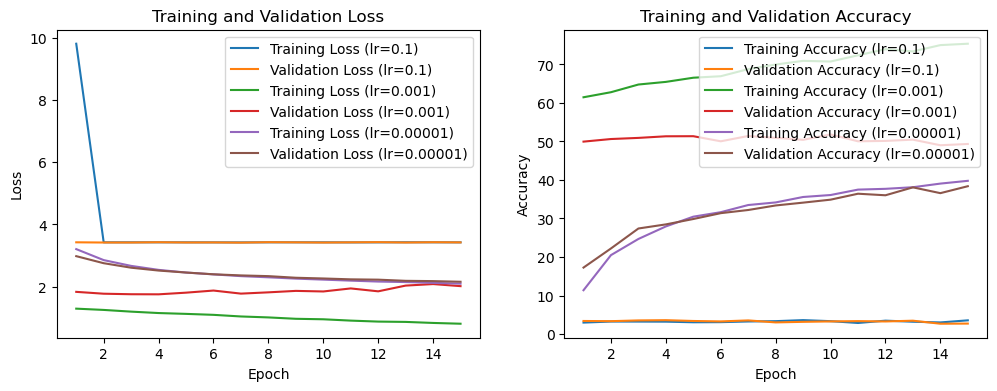

In [ ]:
# graphs for loss and accuracy showing performance at three different learning rates

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

epoch = [i for i in range(1,16)]

train_acc_hpt1 = [a.cpu().numpy() for a in train_acc_hpt1]
val_acc_hpt1 = [a.cpu().numpy() for a in val_acc_hpt1]
train_acc_hpt2 = [a.cpu().numpy() for a in train_acc_hpt2]
val_acc_hpt2 = [a.cpu().numpy() for a in val_acc_hpt2]
train_acc_hpt3 = [a.cpu().numpy() for a in train_acc_hpt3]
val_acc_hpt3 = [a.cpu().numpy() for a in val_acc_hpt3]

axs[0].plot(epoch, train_loss_hpt1, label=f'Training Loss (lr=0.1)')
axs[0].plot(epoch, val_loss_hpt1, label=f'Validation Loss (lr=0.1)')
axs[0].plot(epoch, train_loss_hpt2, label=f'Training Loss (lr=0.001)')
axs[0].plot(epoch, val_loss_hpt2, label=f'Validation Loss (lr=0.001)')
axs[0].plot(epoch, train_loss_hpt3, label=f'Training Loss (lr=0.00001)')
axs[0].plot(epoch, val_loss_hpt3, label=f'Validation Loss (lr=0.00001)')

axs[1].plot(epoch, train_acc_hpt1, label=f'Training Accuracy (lr=0.1)')
axs[1].plot(epoch, val_acc_hpt1, label=f'Validation Accuracy (lr=0.1)')
axs[1].plot(epoch, train_acc_hpt2, label=f'Training Accuracy (lr=0.001)')
axs[1].plot(epoch, val_acc_hpt2, label=f'Validation Accuracy (lr=0.001)')
axs[1].plot(epoch, train_acc_hpt3, label=f'Training Accuracy (lr=0.00001)')
axs[1].plot(epoch, val_acc_hpt3, label=f'Validation Accuracy (lr=0.00001)')
        
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss') 
axs[0].legend()

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()
    
plt.show()

### Model testing

In [ ]:
#Custom Dataset class for unlabled test data

class TestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_list = os.listdir(data_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.image_list[index])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        filename = os.path.basename(image_path)
        return image, filename

In [ ]:
# Create an instance of the TestDataset class
test_data = TestDataset(data_dir=test_dir, transform=transforms.ToTensor())

# Create a data loader for the test data
test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=2)
test_loader

In [ ]:
# Load the trained model
# model = torch.load('path/to/trained/model')
model_cnn_da.eval()

model_cnn_da = model_cnn_da.to(device)

# Generate predictions for the test data
filenames = []
predicted_classes = []
with torch.no_grad():
    for inputs, paths in test_loader:
      inputs = inputs.to(device)
      outputs = model_cnn_da(inputs)
      #outputs = model_cnn_da(inputs).to(device)
      _, preds = torch.max(outputs, 1)
      for i in range(inputs.size(0)):
        filenames.append(paths[i])
        predicted_classes.append(preds[i].item())

In [ ]:
# Save the predicted classes and filenames to a CSV file
import pandas as pd
df = pd.DataFrame({'Id': filenames, 'Category': predicted_classes})
df.to_csv('/kaggle/working/sc22tmj.csv', index=False)


### Model Fine-tuning/transfer learning on CIFAR10 dataset 


   - Download dataset using ``torchvision.datasets.CIFAR10``, [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here are only 10*


In [ ]:
# transform

transform_cifar = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

In [ ]:
# Download the CIFAR10 datasets

import torchvision.datasets as datasets

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
import torch.utils.data as data

train_size = int(0.8 * len(train_dataset)) # Use 80% of the data for training
val_size = len(train_dataset) - train_size # Use the remaining 20% for validation

train_cifar, val_cifar = data.random_split(train_dataset, [train_size, val_size],generator=torch.Generator().manual_seed(0))

In [ ]:
train_loader_cifar = torch.utils.data.DataLoader(train_cifar, batch_size=32, shuffle=True, num_workers=2)
val_loader_cifar = torch.utils.data.DataLoader(val_cifar, batch_size=32, shuffle=False, num_workers=2)

> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [ ]:
import torchvision.models as models

# Load pre-trained AlexNet model
Alexnet = models.alexnet(pretrained=True)

Alexnet.classifier[6] = nn.Linear(4096,10)

Alexnet.to(device)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### 4.1 Applying transfer learning initialise with pretrained model weights
Using pretrained weights from AlexNet only (on the right of figure) to initialise the model. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" style="width:1000px;height:400px;">
<caption><center> <u>Figure</u></center></caption>


> Configuration 1: No frozen layers

In [ ]:
optimizer_cifar1 = optim.Adam(Alexnet.parameters(), lr=0.001)

In [ ]:
# create lists to store loss and accuracy values for training and validation sets
train_loss_cifar1 = []
train_acc_cifar1 = []
val_loss_cifar1 = []
val_acc_cifar1 = []

# Running the Alexnet model class

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_cifar1 = timer() 

# Train and test model
epochs = 10
for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc = train_step(model=Alexnet,
             data_loader=train_loader_cifar,
             loss_fn=loss_fn,
             optimizer=optimizer_cifar1,
             device=device)
  val_loss, val_acc = valid_step(model=Alexnet,
            data_loader=val_loader_cifar,
            loss_fn=loss_fn,
            device=device)
  train_loss_cifar1.append(train_loss)
  train_acc_cifar1.append(train_acc)
  val_loss_cifar1.append(val_loss.cpu().numpy())
  val_acc_cifar1.append(val_acc)

train_time_end_model_cifar1 = timer()
total_train_time_model_cifar1 = print_train_time(start=train_time_start_model_cifar1,
                                            end=train_time_end_model_cifar1,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 2.30725 | Train acc: 9.87%
Validation loss: 2.30321 | Validation acc: 9.88%

Epoch: 2
-------
Train loss: 2.30375 | Train acc: 10.02%
Validation loss: 2.30286 | Validation acc: 10.19%

Epoch: 3
-------
Train loss: 2.30315 | Train acc: 9.80%
Validation loss: 2.30376 | Validation acc: 9.82%

Epoch: 4
-------
Train loss: 2.30337 | Train acc: 9.95%
Validation loss: 2.30263 | Validation acc: 9.84%

Epoch: 5
-------
Train loss: 2.30329 | Train acc: 9.88%
Validation loss: 2.30340 | Validation acc: 9.88%

Epoch: 6
-------
Train loss: 2.30339 | Train acc: 9.89%
Validation loss: 2.30271 | Validation acc: 9.90%

Epoch: 7
-------
Train loss: 2.30324 | Train acc: 9.77%
Validation loss: 2.30268 | Validation acc: 9.90%

Epoch: 8
-------
Train loss: 2.30320 | Train acc: 10.16%
Validation loss: 2.30302 | Validation acc: 10.05%

Epoch: 9
-------
Train loss: 2.30328 | Train acc: 9.87%
Validation loss: 2.30306 | Validation acc: 10.05%

Epoch: 10
-------
Train loss: 2.30324 | T

#### Fine-tuning model with frozen layers

In [ ]:
Alexnet_2=models.alexnet(pretrained=True)

# freeze convolution blocks
for param in Alexnet_2.parameters():
    param.requires_grad = False

Alexnet_2.classifier[6] = torch.nn.Linear(4096, 10)

Alexnet_2.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
optimizer_cifar2 = optim.Adam(Alexnet_2.parameters(), lr=0.001)

In [ ]:
# create lists to store loss and accuracy values for training and validation sets
train_loss_cifar2 = []
train_acc_cifar2 = []
val_loss_cifar2 = []
val_acc_cifar2 = []

# Running the Alexnet model class

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_cifar2 = timer() 

# Train and test model
epochs = 10
for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc = train_step(model=Alexnet_2,
             data_loader=train_loader_cifar,
             loss_fn=loss_fn,
             optimizer=optimizer_cifar2,
             device=device)
  val_loss, val_acc = valid_step(model=Alexnet_2,
            data_loader=val_loader_cifar,
            loss_fn=loss_fn,
            device=device)
  train_loss_cifar2.append(train_loss)
  train_acc_cifar2.append(train_acc)
  val_loss_cifar2.append(val_loss.cpu().numpy())
  val_acc_cifar2.append(val_acc)

train_time_end_model_cifar2 = timer()
total_train_time_model_cifar2 = print_train_time(start=train_time_start_model_cifar2,
                                            end=train_time_end_model_cifar2,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 1.21638 | Train acc: 56.83%
Validation loss: 1.02468 | Validation acc: 63.69%

Epoch: 2
-------
Train loss: 1.12819 | Train acc: 60.47%
Validation loss: 0.92744 | Validation acc: 67.64%

Epoch: 3
-------
Train loss: 1.10553 | Train acc: 61.22%
Validation loss: 0.93841 | Validation acc: 67.24%

Epoch: 4
-------
Train loss: 1.08954 | Train acc: 61.80%
Validation loss: 0.90888 | Validation acc: 68.87%

Epoch: 5
-------
Train loss: 1.09149 | Train acc: 62.07%
Validation loss: 0.92283 | Validation acc: 68.06%

Epoch: 6
-------
Train loss: 1.08079 | Train acc: 62.13%
Validation loss: 0.93355 | Validation acc: 67.18%

Epoch: 7
-------
Train loss: 1.08301 | Train acc: 62.30%
Validation loss: 0.92683 | Validation acc: 67.39%

Epoch: 8
-------
Train loss: 1.08248 | Train acc: 62.25%
Validation loss: 0.90169 | Validation acc: 68.11%

Epoch: 9
-------
Train loss: 1.07753 | Train acc: 62.48%
Validation loss: 0.89129 | Validation acc: 68.53%

Epoch: 10
-------
Train loss

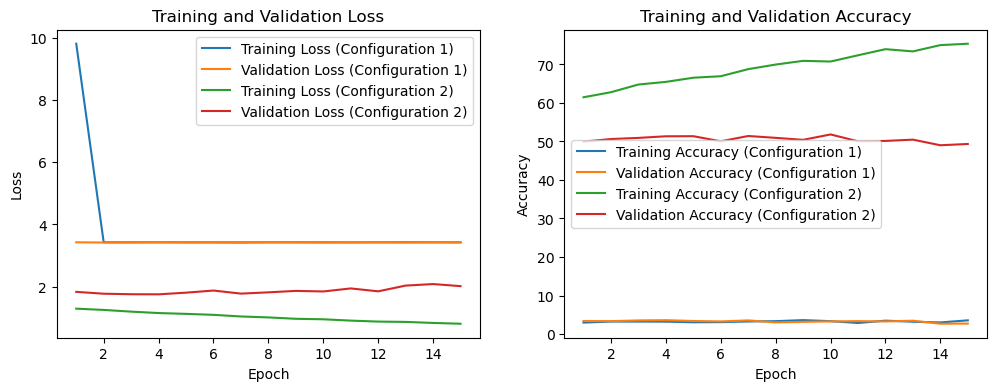

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

train_loss_cifar1 = []
train_acc_cifar1 = []
val_loss_cifar1 = []
val_acc_cifar1 = []

epoch = [i for i in range(1,16)]

# train_acc_hpt1 = [a.cpu().numpy() for a in train_acc_hpt1]
# val_acc_hpt1 = [a.cpu().numpy() for a in val_acc_hpt1]
# train_acc_hpt2 = [a.cpu().numpy() for a in train_acc_hpt2]
# val_acc_hpt2 = [a.cpu().numpy() for a in val_acc_hpt2]

axs[0].plot(epoch, train_loss_hpt1, label=f'Training Loss (Configuration 1)')
axs[0].plot(epoch, val_loss_hpt1, label=f'Validation Loss (Configuration 1)')
axs[0].plot(epoch, train_loss_hpt2, label=f'Training Loss (Configuration 2)')
axs[0].plot(epoch, val_loss_hpt2, label=f'Validation Loss (Configuration 2)')

axs[1].plot(epoch, train_acc_hpt1, label=f'Training Accuracy (Configuration 1)')
axs[1].plot(epoch, val_acc_hpt1, label=f'Validation Accuracy (Configuration 1)')
axs[1].plot(epoch, train_acc_hpt2, label=f'Training Accuracy (Configuration 2)')
axs[1].plot(epoch, val_acc_hpt2, label=f'Validation Accuracy (Configuration 2)')
        
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss') 
axs[0].legend()

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()
    
plt.show()

The above graph shows that AlexNet model with Configuration 2, that is with frozen base convolution blocks performs better than with Configuration 1 without any frozen layers. The accuracy is better for configuration 2 as well as lower loss. 

Lower loss and higher accuracy are the indicators of better performance of the model. This suggests that the pre-trained features learned by the convolution blocks are useful in improving the overall performance of the model.

### Model comparisons

In [ ]:
#Loading pretrained AlexNet model

import torchvision.models as models

alexnet = models.alexnet(pretrained=True)

# Modify the last few layers differently for another configuration
alexnet.classifier[6] = torch.nn.Linear(4096, 30)

alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
optimizer_alexnet = torch.optim.SGD(params=alexnet.parameters(),
                            lr=0.01)

In [ ]:
# create lists to store loss and accuracy values for training and validation sets
train_loss_alexnet = []
train_acc_alexnet = []
val_loss_alexnet = []
val_acc_alexnet = []

In [ ]:
# Running the Alexnet model class

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_3 = timer() 

# Train and test model
epochs = 10
for epoch in tqdm(range(1, epochs+1)):
  print(f"Epoch: {epoch}\n-------")
  train_loss, train_acc = train_step(model=alexnet,
             data_loader=train_dataloader_custom,
             loss_fn=loss_fn,
             optimizer=optimizer_alexnet,
             device=device)
  val_loss, val_acc = valid_step(model=alexnet,
            data_loader=val_dataloader_custom,
            loss_fn=loss_fn,
            device=device)
  train_loss_alexnet.append(train_loss)
  train_acc_alexnet.append(train_acc)
  val_loss_alexnet.append(val_loss.cpu().numpy())
  val_acc_alexnet.append(val_acc)

train_time_end_model_3 = timer()
total_train_time_model_3 = print_train_time(start=train_time_start_model_3,
                                            end=train_time_end_model_3,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 2.16198 | Train acc: 39.51%
Validation loss: 1.81280 | Validation acc: 47.60%

Epoch: 2
-------
Train loss: 1.65037 | Train acc: 51.32%
Validation loss: 1.71692 | Validation acc: 51.15%

Epoch: 3
-------
Train loss: 1.47160 | Train acc: 56.68%
Validation loss: 1.67007 | Validation acc: 53.05%

Epoch: 4
-------
Train loss: 1.33801 | Train acc: 60.24%
Validation loss: 1.54544 | Validation acc: 54.75%

Epoch: 5
-------
Train loss: 1.21806 | Train acc: 62.98%
Validation loss: 1.48755 | Validation acc: 56.27%

Epoch: 6
-------
Train loss: 1.14112 | Train acc: 65.07%
Validation loss: 1.52059 | Validation acc: 57.79%

Epoch: 7
-------
Train loss: 1.06743 | Train acc: 67.45%
Validation loss: 1.70934 | Validation acc: 55.45%

Epoch: 8
-------
Train loss: 0.99689 | Train acc: 68.99%
Validation loss: 1.49921 | Validation acc: 57.37%

Epoch: 9
-------
Train loss: 0.93174 | Train acc: 71.07%
Validation loss: 1.56548 | Validation acc: 57.70%

Epoch: 10
-------
Train loss

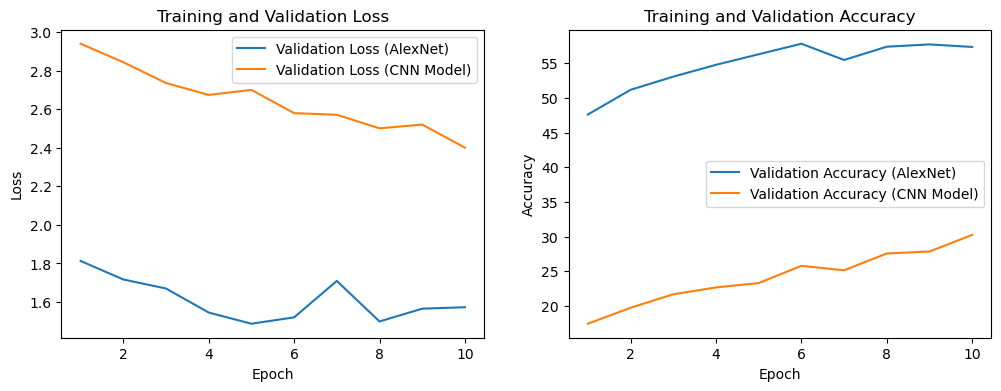

In [ ]:
# Alexnet graph

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

epoch = [i for i in range(1,11)]

train_acc_alexnet = [a.cpu().numpy() for a in train_acc_alexnet]
val_acc_alexnet = [a.cpu().numpy() for a in val_acc_alexnet]
train_acc_CNN_da = [a.cpu().numpy() for a in train_acc_CNN_da]
val_acc_CNN_da = [a.cpu().numpy() for a in val_acc_CNN_da]

axs[0].plot(epoch, val_loss_alexnet, label=f'Validation Loss (AlexNet)')
axs[0].plot(epoch, val_loss_CNN_da[0:10], label=f'Validation Loss (CNN Model)')

axs[1].plot(epoch, val_acc_alexnet, label=f'Validation Accuracy (AlexNet)')
axs[1].plot(epoch, val_acc_CNN_da[0:10], label=f'Validation Accuracy (CNN Model)')
        
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss') 
axs[0].legend()

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()
    
plt.show()

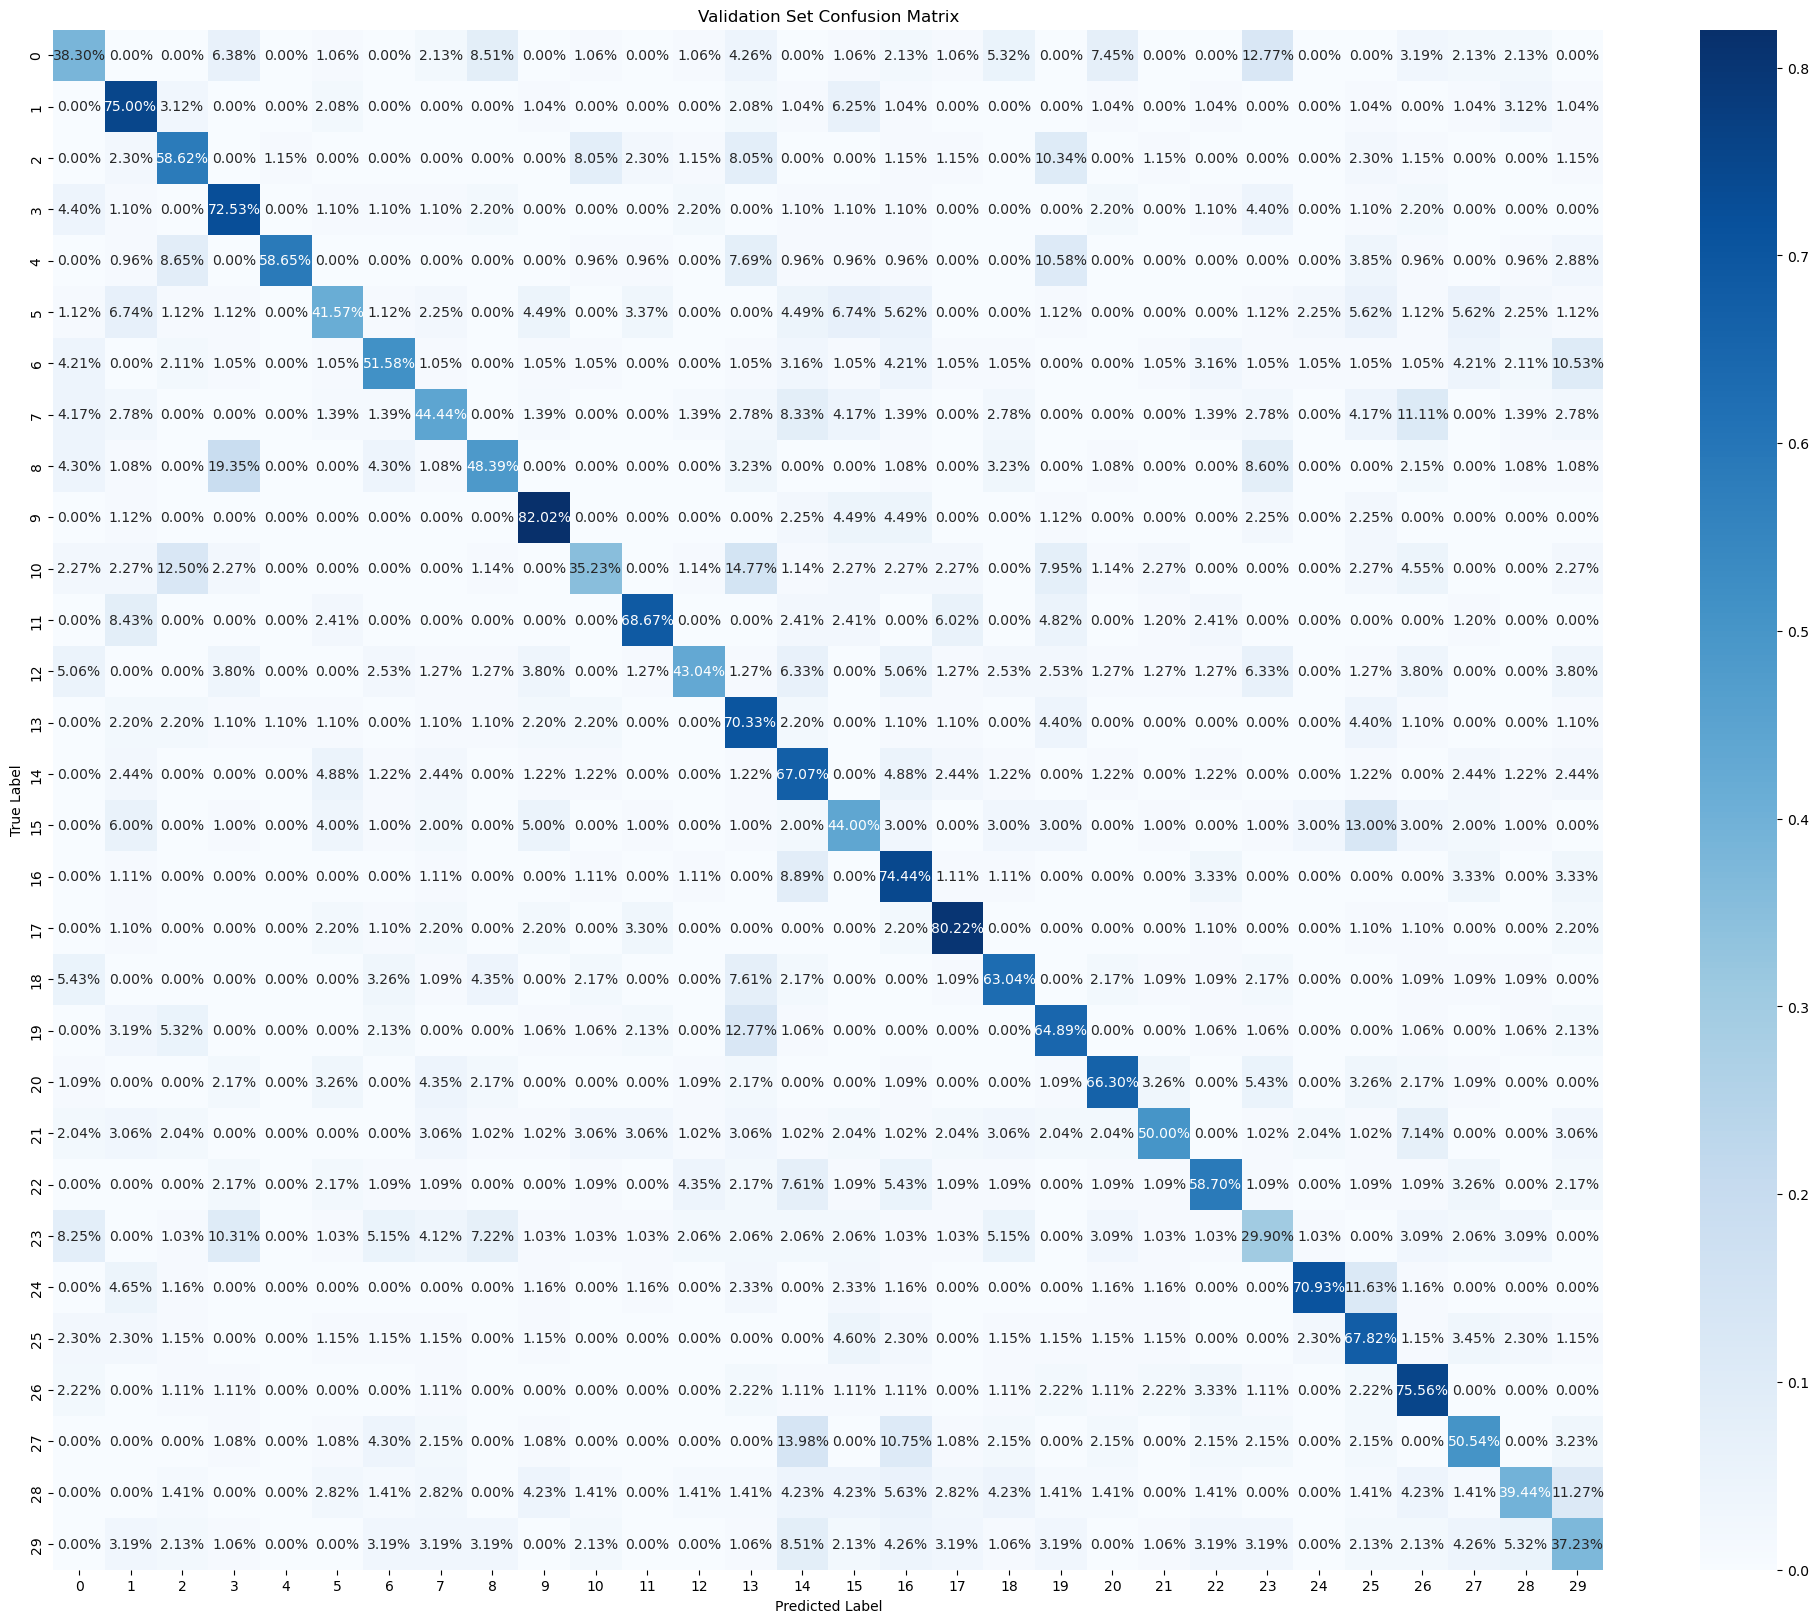

In [ ]:
# Confusion Matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define function to generate confusion matrix
def generate_confusion_matrix(model, data_loader):
    num_classes = len(train_data_custom.classes)
    confusion_matrix = np.zeros((num_classes, num_classes))
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(predicted)):
                confusion_matrix[labels[i]][predicted[i]] += 1
    return confusion_matrix

# Generate confusion matrix for validation set
val_confusion_matrix = generate_confusion_matrix(alexnet, val_dataloader_custom)
val_percentages = val_confusion_matrix / np.sum(val_confusion_matrix, axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(val_percentages, annot=True, fmt=".2%", cmap="Blues")
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print(f"Execution time for CNN Base Model on {device} for 10 Epochs: {total_train_time_model_2:.3f} seconds")
print(f"Execution time for Alexnet on {device} for 10 Epochs: {total_train_time_model_3:.3f} seconds")

Execution time for CNN Base Model on cuda for 10 Epochs: 303.153 seconds
Execution time for Alexnet on cuda for 10 Epochs: 150.387 seconds


### Interpretation of results

In [21]:
!pip install torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from torchcam.methods import SmoothGradCAMpp

model_g1 = CNNModel(input_shape=3,
                   hidden_units=50,
                   output_shape=len(train_data_custom.classes)).to(device)

model_g1.load_state_dict(torch.load('/content/drive/MyDrive/FinalCNN_da.pth', map_location=torch.device('cpu')))

model_g1.to(device)

CNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0)

In [23]:
correct_images = []
with torch.no_grad():
    for X, y in val_dataloader_custom:
        X = X.to(device)
        y = y.to(device)
        y_preds = model_g1(X)
        predicted_classes = torch.argmax(y_preds, dim=1)
        correct_mask = predicted_classes == y
        correct_images_batch = X[correct_mask]
        correct_images.extend(correct_images_batch.cpu())
        correct_images = correct_images[0:4]
        if len(correct_images) >= 4:
            break

In [24]:
# save the correct images to disk
for i, image in enumerate(correct_images):
    image = transforms.functional.to_pil_image(image)
    image.save(f'correct_image_{i}.JPEG')

In [25]:
def preprocess_image(img_path):
    img = Image.open(img_path)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img = transform(img)
    return img

In [26]:
# Load your test images from the folder gradcam-correct

image_paths = ["/content/correct_image_0.JPEG","/content/correct_image_1.JPEG","/content/correct_image_2.JPEG","/content/correct_image_3.JPEG"]

images = [preprocess_image(img_path) for img_path in image_paths]

In [27]:
# Define the SmoothGradCAMpp object
cam_extractor = SmoothGradCAMpp(model=model_g1, input_shape=(3, 64, 64))

In [28]:
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

image1 = images[0].to(device)
image2 = images[1].to(device)
image3 = images[2].to(device)
image4 = images[3].to(device)

# Preprocess your data and feed it to the model
output1 = model_g1(image1.unsqueeze(0))
output2 = model_g1(image2.unsqueeze(0))
output3 = model_g1(image3.unsqueeze(0))
output4 = model_g1(image4.unsqueeze(0))

# Retrieve the CAM by passing the class index and the model output
activation_map1 = cam_extractor(output1.squeeze(0).argmax().item(), output1)
activation_map2 = cam_extractor(output2.squeeze(0).argmax().item(), output2)
activation_map3 = cam_extractor(output3.squeeze(0).argmax().item(), output3)
activation_map4 = cam_extractor(output4.squeeze(0).argmax().item(), output4)
   
# Resize the CAM and overlay it
result1 = overlay_mask(to_pil_image(image1), to_pil_image(activation_map1[0].squeeze(0), mode='F'), alpha=0.5)
result2 = overlay_mask(to_pil_image(image2), to_pil_image(activation_map2[0].squeeze(0), mode='F'), alpha=0.5)
result3 = overlay_mask(to_pil_image(image3), to_pil_image(activation_map3[0].squeeze(0), mode='F'), alpha=0.5)
result4 = overlay_mask(to_pil_image(image4), to_pil_image(activation_map4[0].squeeze(0), mode='F'), alpha=0.5)

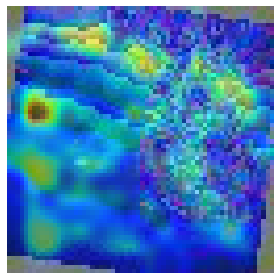

In [30]:
plt.imshow(result2);
plt.axis('off');
plt.tight_layout();
plt.show()

In [32]:
import torchvision.models as models
alexnet_g2 = models.alexnet(pretrained=True).to(device)
alexnet_g2.classifier[6] = torch.nn.Linear(4096, 30)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [33]:
alexnet_g2.load_state_dict(torch.load('/content/drive/MyDrive/alexnet.pth', map_location=torch.device('cpu')))
alexnet_g2.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [35]:
incorrect_images = []
with torch.no_grad():
    for X, y in val_dataloader_custom:
        X = X.to(device)
        y = y.to(device)
        y_preds = alexnet_g2(X)
        predicted_classes = torch.argmax(y_preds, dim=1)
        incorrect_mask = predicted_classes != y
        incorrect_images_batch = X[incorrect_mask]
        incorrect_images.extend(incorrect_images_batch.cpu())
        incorrect_images = incorrect_images[0:4]
        if len(incorrect_images) >= 4:
            break

In [36]:
for i, image in enumerate(incorrect_images):
    image = transforms.functional.to_pil_image(image)
    image.save(f'incorrect_image_{i}.JPEG')

In [37]:
# Load your test images from the folder gradcam-correct

image_paths = ["/content/incorrect_image_0.JPEG","/content/incorrect_image_1.JPEG","/content/incorrect_image_2.JPEG","/content/incorrect_image_3.JPEG"]

images = [preprocess_image(img_path) for img_path in image_paths]

In [38]:
cam_extractor_i = SmoothGradCAMpp(model=alexnet_g2, input_shape=(3, 64, 64))

In [39]:
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

iimage1 = images[0].to(device)
iimage2 = images[1].to(device)
iimage3 = images[2].to(device)
iimage4 = images[3].to(device)

# Preprocess your data and feed it to the model
ioutput1 = model_g1(iimage1.unsqueeze(0))
ioutput2 = model_g1(iimage2.unsqueeze(0))
ioutput3 = model_g1(iimage3.unsqueeze(0))
ioutput4 = model_g1(iimage4.unsqueeze(0))

# Retrieve the CAM by passing the class index and the model output
activation_map1 = cam_extractor(ioutput1.squeeze(0).argmax().item(), ioutput1)
activation_map2 = cam_extractor(ioutput2.squeeze(0).argmax().item(), ioutput2)
activation_map3 = cam_extractor(ioutput3.squeeze(0).argmax().item(), ioutput3)
activation_map4 = cam_extractor(ioutput4.squeeze(0).argmax().item(), ioutput4)
   
# Resize the CAM and overlay it
iresult1 = overlay_mask(to_pil_image(iimage1), to_pil_image(activation_map1[0].squeeze(0), mode='F'), alpha=0.5)
iresult2 = overlay_mask(to_pil_image(iimage2), to_pil_image(activation_map2[0].squeeze(0), mode='F'), alpha=0.5)
iresult3 = overlay_mask(to_pil_image(iimage3), to_pil_image(activation_map3[0].squeeze(0), mode='F'), alpha=0.5)
iresult4 = overlay_mask(to_pil_image(iimage4), to_pil_image(activation_map4[0].squeeze(0), mode='F'), alpha=0.5)

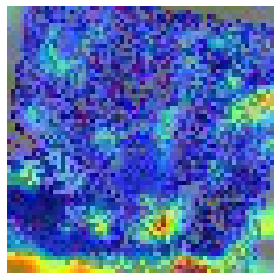

In [41]:
plt.imshow(iresult4);
plt.axis('off');
plt.tight_layout();
plt.show()

---> GradCAM is a technique that helps to visualize the regions of the input image that contributed to the final prediction of a deep learning model. Here, when applying GradCAM to correctly classified images, the visualization highlights the regions of the image that contributed the most to the correct prediction. On the other hand, when applying GradCAM to incorrectly classified images, the visualization highlights the regions of the image that led to the incorrect prediction.

By examining the visualizations generated by GradCAM, we can get a better understanding of which regions of the image are being used by the model to make its predictions. This can be useful in identifying potential areas of improvement in the model or in understanding the model's decision-making process.